In [95]:
import nashpy as nash
import numpy as np
import operator
from scipy.stats import logistic
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [96]:
#incentives
s= 2.5 # sell_grid
b= .1 # buy_grid

#price elasticity
k = .1 #unitary



In [97]:
def __price__(prev_price=0,
            pr_el=k,
            tr_1=0,
            tr_2=0
            ):

    price = prev_price + pr_el*(tr_1 - tr_2)
    if price < 0:
        price = prev_price
        #print('New price too low, old price stays')
    return price



In [98]:
class Player():
    def __init__(self,name,
                renewable_boundaries=(0.1,1),
                mean_consumption=0.3,
                std_consumption=0.05,
                c_up = 1. ,  #max storage
                c_down = .30, #min to work
                price = 1.
                
            ):
        
        self.name = name    
        #self.energy = 0 # energy transfer
        #self.energy_supply = 0 #energy available - consumption
        self.battery_status = 0.5
        self.mean_consumption = mean_consumption # mean energy needed
        self.energy_consumption = np.random.normal(self.mean_consumption, scale=std_consumption) # energy consumption is normal distributed
        self.battery_capacity = c_up
        self.battery_min = c_down
        self.uniform_boundaries = renewable_boundaries # boundaries for uniform probability for of renewable energy
        self.renewable_energy = np.random.uniform(*self.uniform_boundaries)
        self.utility = 0
        self.delta = self.renewable_energy - self.energy_consumption

    def energy_supply(self):
            energy_supply = self.renewable_energy - self.energy_consumption
            self.battery_status += energy_supply 
            #self.energy = 0
            return self.battery_status

    def new_day(self):
        self.energy_consumption = np.random.normal(self.mean_consumption, scale=0.05)
        self.renewable_energy = np.random.uniform(*self.uniform_boundaries)
    
    def do_nothing(self):
        self.utility = 0
    
    def buy_energy(self, energy_to_buy, smartgrid_transfer, price): #from the smartgrid
        #self.energy += energy_to_buy
        self.utility=0
        self.battery_status += energy_to_buy
        if smartgrid_transfer > 0:
            if energy_to_buy >= smartgrid_transfer:
                self.utility = -price*(b*smartgrid_transfer + (energy_to_buy - smartgrid_transfer))
            else:
                self.utility = -price*b*energy_to_buy
        else:
            self.utility = -price*energy_to_buy
            
    def sell_energy(self, energy_to_sell, smartgrid_transfer, price): #to the smartgrid
        #self.energy -= energy_to_sell
        self.utility = 0
        self.battery_status -= energy_to_sell
        if smartgrid_transfer > 0:
            if energy_to_sell >= smartgrid_transfer:
                self.utility = price* (s*smartgrid_transfer + (energy_to_sell - smartgrid_transfer))
            else:
                self.utility = price*s*energy_to_sell #- price*(smartgrid_transfer - energy_to_sell) #added the second components to penalize the seller greediness
        else:
            self.utility = price*energy_to_sell

In [99]:
def static_game(players = [], days=100):
    
    num_players = len(players) # number of players
    utility = np.zeros(shape=(num_players, days)) # utility of every player on every day
    game_state = np.zeros(shape=(num_players, days)) # battery of every player on every day
    price_series = np.zeros(shape=(1, days))
    transfer = np.zeros(shape=(days))
    price =__price__()
  
    for w in range(days):

        utility[:,w] = [x.utility for x in players]
        game_state[:,w] = [x.battery_status for x in players]
        price_series[0, w] = price
        seller = np.array([]) # list of players that want to sell today
        buyer = np.array([]) # list of players that want to buy today
        idle = np.array([]) # list of players that want to stay idle

        for i in players:
            if (i.delta + i.battery_status) <= i.battery_min and i.delta < 0 : 
                i.want_buy = True
                buyer = np.append(buyer, i)
        
            elif (i.delta + i.battery_status) > i.battery_min and i.delta < 0 : 
                actions = [0, 1] #0=nothing 1=buy
                choice = random.choice(actions)
                if choice == 1:
                    i.want_buy = True
                    buyer = np.append(buyer, i)
                else:
                    idle = np.append(idle, i)
            elif (i.delta + i.battery_status) < i.battery_capacity and i.delta >= 0 : 
                actions = [0, 1] #0=nothing 1=sell
                choice = random.choice(actions)
                if choice == 1:
                    i.want_sell = True
                    seller = np.append(seller, i)
                else:
                    idle = np.append(idle, i)     
            elif (i.delta + i.battery_status) >= i.battery_capacity and i.delta >= 0 : 
                i.want_sell = True
                seller = np.append(seller, i)
            else:
                continue

        buyer = sorted(buyer, key=operator.attrgetter('battery_status')) # the buyer with the highest need buys first
        #seller = sorted(seller, key=operator.attrgetter('sell_price')) # seller sorted after their prices
        
        for i in idle:
            i.do_nothing
            
        global tr_max 
        tr_max = 0
        for i in buyer:    
            for j in seller:
                global energy_s, energy_b
                energy_s = j.delta + j.battery_status - 1.*j.battery_min
                energy_b = 1.*i.battery_capacity - i.battery_status -i.delta
                tr_max = max(energy_b, energy_s) #max amount of energy transfer during the daily exchange
                i.buy_energy(energy_b, energy_s, price)
                j.sell_energy(energy_s, energy_b,price)
        # for i in seller:
        #     for j in buyer:
        #         global energy_transfer_b
        #         energy_transfer_b = -j.delta - j.battery_status + j.battery_capacity
        #         i.sell_energy(j.delta + j.battery_status - j.battery_min, energy_transfer_b, price)
        
        transfer[w]= tr_max
        
        price =__price__(prev_price=price,
                pr_el=k,
                tr_1=transfer[w-1],
                tr_2=transfer[w-2]
                )

        
        for x in players: # start a new day -> new random variables for consumption and renewable energy
            x.new_day()
            x.energy_supply()

    return utility, game_state, price_series

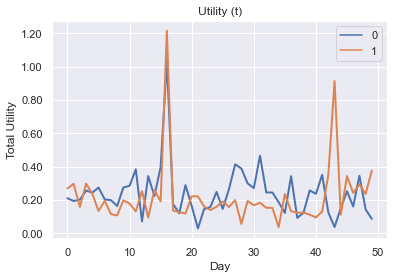

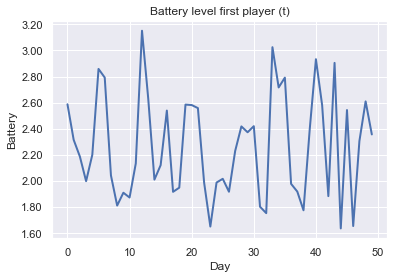

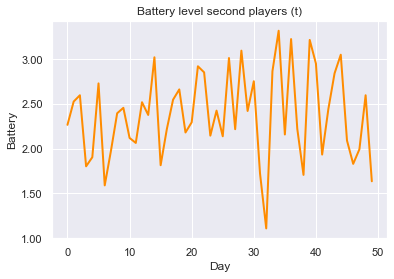

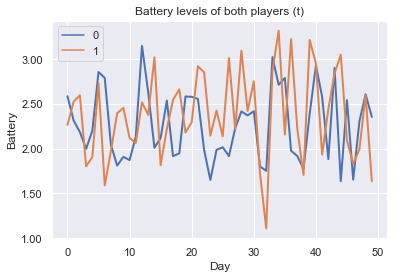

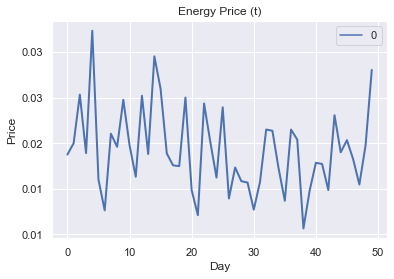

In [100]:
from matplotlib.ticker import StrMethodFormatter

utility = np.array([])
game_state = np.array([])
price_series = np.array([])
N = 1000
T = 50
for i in range(N):
    A = Player('A',
                renewable_boundaries=(0.1,1.),
                mean_consumption=0.4,
                std_consumption=0.02,
                c_up = 1. ,  
                c_down = .30,
                price = 1) 
    B = Player('B',
                renewable_boundaries=(0.1,1.),
                mean_consumption=0.4,
                std_consumption=0.02,
                c_up = 1. ,  
                c_down = .30,
                price = 1) 
    trial_utility, trial_game_state, trial_price_series = static_game([A, B], T)
    utility = np.append(utility, np.cumsum(trial_utility))
    game_state = np.append(game_state, trial_game_state)
    price_series = np.append(price_series, trial_price_series)
utility = utility.reshape(2, T, N)
utility = np.mean(utility, axis=2)
game_state = game_state.reshape(2, T, N)
game_state = np.mean(game_state, axis=2)
price_series = price_series.reshape(1, T, N)
price_series = np.mean(price_series, axis=2)

sns.set_theme(style="darkgrid")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:2.2f}'))
sns.lineplot(data=utility.T, lw=2, dashes=False)
plt.title('Utility (t)')
plt.ylabel('Total Utility')
plt.xlabel('Day')
plt.show()
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:02.2f}'))
sns.lineplot(data=game_state[0].T, lw=2, dashes=False)
plt.title('Battery level first player (t)')
plt.ylabel('Battery')
plt.xlabel('Day')
plt.show()#1player
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:02.2f}'))
sns.lineplot(data=game_state[1].T, lw=2, dashes=False, color='darkorange')
plt.title('Battery level second players (t)')
plt.ylabel('Battery')
plt.xlabel('Day')
plt.show()#2player
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:02.2f}'))
sns.lineplot(data=game_state.T, lw=2, dashes=False)
plt.title('Battery levels of both players (t)')
plt.ylabel('Battery')
plt.xlabel('Day')
plt.show()#both players
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:02.2f}'))
sns.lineplot(data=price_series.T, lw=2, dashes=False)
plt.title('Energy Price (t)')
plt.ylabel('Price')
plt.xlabel('Day')
plt.show()